In [1]:
%pip install langgraph -q 

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install langchain-groq -q 

Note: you may need to restart the kernel to use updated packages.


In [34]:
import getpass
import os



os.environ["GROQ_API_KEY"] = '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'

In [2]:
from typing import TypedDict
from typing import Literal
from langgraph.graph import StateGraph, START, END


In [3]:
class EmailState(TypedDict):
    email: dict
    body: str
    isSpam: bool
    reply: str


In [35]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [36]:
llm.invoke("What is the capital of India ?")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 42, 'total_tokens': 51, 'completion_time': 0.032727273, 'prompt_time': 0.003252344, 'queue_time': 0.054129117000000004, 'total_time': 0.035979617}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'stop', 'logprobs': None}, id='run-88eed859-5704-4968-8f30-b547cdc5ff97-0', usage_metadata={'input_tokens': 42, 'output_tokens': 9, 'total_tokens': 51})

In [45]:
def email_stripper(state: EmailState):
    print("\nStripping the email body \n")
    email = state["email"]
    prompt = f""" For the given email seperate out the body of the email, output only the body of the email.
                email = {email}"""
    body = llm.invoke(prompt)
    EmailState.body = body.content
    print(f"\nEmail body stripped: {EmailState.body}\n")

def spam_filter(state: EmailState):
    print("\nClassifying the email as spam or not spam \n")
    email_body = EmailState.body
    prompt = f"""For the given email you have to classify if this email is spam or not, Output only spam or not spam
                email = {email_body}"""
    isSpam = llm.invoke(prompt)
    if isSpam.content.lower() == "spam":
        EmailState.isSpam = True
    else:
        EmailState.isSpam = False
    print(f"\nEmail classified as: {EmailState.isSpam}\n")

def email_router(state: EmailState):
    if EmailState.isSpam:
        return "spam"
    else:
        return "not spam"

def email_reply(state: EmailState):
    print("\nGenerating the reply to the email \n")
    email_body = EmailState.body
    prompt = f"""You are a helpful assistant, you have to reply to the given email.
                body = {EmailState.body}"""
    reply = llm.invoke(prompt)
    EmailState.reply = reply.content
    print(f"\nReply generated: {EmailState.reply}\n")

graph_builder = StateGraph(EmailState)

graph_builder.add_node("email_stripper", email_stripper)
graph_builder.add_node("spam_filter", spam_filter)
graph_builder.add_node("email_reply", email_reply)

graph_builder.add_edge(START, "email_stripper")
graph_builder.add_conditional_edges("spam_filter", email_router, {
    "not spam": "email_reply",
    "spam": END
})
graph_builder.add_edge("email_stripper", "spam_filter")
graph_builder.add_edge("email_reply", END)

graph = graph_builder.compile()

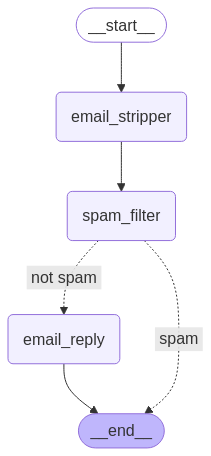

In [40]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}
compiled_input = {
    "email": spam_email,
    "body" : None, 
    "isSpam" : False,
    "reply" : None
}
result = graph.invoke(compiled_input)
print(result)


Stripping the email body 


Email body stripped: CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.


Classifying the email as spam or not spam 


Email classified as: True

{'email': {'sender': 'winner@lottery-intl.com', 'subject': 'YOU HAVE WON $5,000,000!!!', 'body': 'CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.'}, 'body': None, 'isSpam': False, 'reply': None}
